### Package imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

### Import the dataset
The datasets contains data of claim counts for different policyholders with certain characteristics. The columns of the dataset are:
   - **AGEPH**: Age of policyholder.
   - **CODPOSS**: Postal code of residency.
   - **duree**: Exposure rate.
   - **lnexpo**: Logarithm of exposure rate.
   - **nbrtotc**: Number of total claims.
   - **nbrtotan**: ?
   - **chargtot**: Total claim amount.
   - **agecar**: Age of car.
   - **sexp**: Sex of person.
   - **fuelc**: Type of fuel of car.
   - **split**: How many splits for the yearly payment.
   - **usec**: Professional or private use of the car.
   - **fleetc**: Is car part of a fleet?
   - **sportc**: Is car a sports car?
   - **coverp**: Type of cover.
   - **powerc**: Power of the car.

In [3]:
df = pd.read_csv('../data/portfolio_data.csv')
df.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


### Some preprocessing
 - Change column names to lower case
 - Change column names to more descriptive names
 - Change datatypes of columns (in this case all 'objects'should be 'categorical')

In [4]:
df = df.rename(lambda x: x.lower(), axis=1)
df = df.rename(columns={'duree': 'exposure'})

df['weighted_nbrtotc'] = df['nbrtotc'] / df['exposure']
df['agecar'] = pd.Categorical(df['agecar'], ordered=True, categories=['0-1', '2-5', '6-10', '>10'])
df['sexp'] = pd.Categorical(df['sexp'], categories=['Male', 'Female'])
df['fuelc'] = pd.Categorical(df['fuelc'], categories=['Petrol', 'Gasoil'])
df['split'] = pd.Categorical(df['split'], categories=['Once', 'Twice', 'Thrice', 'Monthly'])
df['usec'] = pd.Categorical(df['usec'], categories=['Private', 'Professional'])
df['fleetc'] = pd.Categorical(df['fleetc'], categories=['No', 'Yes'])
df['sportc'] = pd.Categorical(df['sportc'], categories=['No', 'Yes'])
df['coverp'] = pd.Categorical(df['coverp'], categories=['MTPL', 'MTPL+', 'MTPL+++'])
df['powerc'] = pd.Categorical(df['powerc'], ordered=True, categories=['<66', '66-110', '>110'])

df.dtypes

ageph                  int64
codposs                int64
exposure             float64
lnexpo               float64
nbrtotc                int64
nbrtotan             float64
chargtot             float64
agecar              category
sexp                category
fuelc               category
split               category
usec                category
fleetc              category
sportc              category
coverp              category
powerc              category
weighted_nbrtotc     float64
dtype: object

## Explaratory Data Analysis
### Getting some insights in the data by looking at distributions of all the columns

We want to predict the number of claims, let's first look at this variable (**nbrtotc**)

0    145312
1     16602
2      1562
3       162
4        17
5         2
Name: nbrtotc, dtype: int64
Average claim per policyholder: 0.12397880933904447 
Average expected annual claim frequency: 0.1393355156734497 


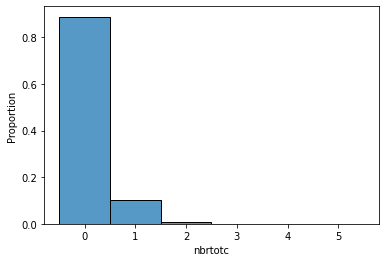

In [5]:
print(df["nbrtotc"].value_counts())
print(f'Average claim per policyholder: {df["nbrtotc"].mean()} ')
print(f'Average expected annual claim frequency: {df["nbrtotc"].sum() / df["exposure"].sum()} ')

sns.histplot(x='nbrtotc', data=df, discrete=True, stat='proportion')
plt.show()

#### Continuous / count data

Let's take a look at our feature variables we can use.
First let's look at the available ages and at the exposure of our policyholders (for what fraction of the year have they been a policyholder). Exposure rate will be used as a weight in our models.

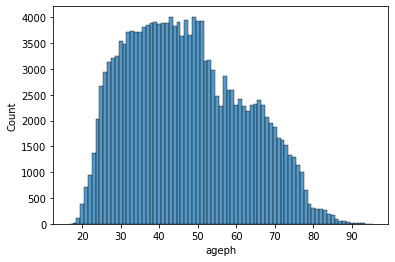

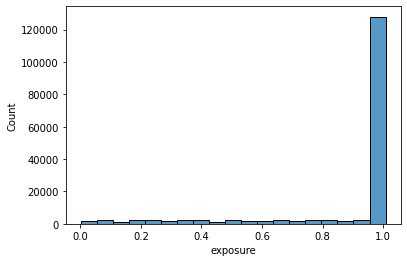

In [6]:
sns.color_palette("light:b", as_cmap=True)
for col in ['ageph', 'exposure']:
    sns.histplot(x=col, data=df, discrete=str(df[col].dtype).startswith('int'))
    plt.show()
    

#### Categorical data
The other predictors are categorical, so let's visualise them in a countplot.

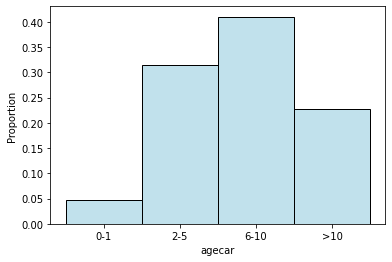

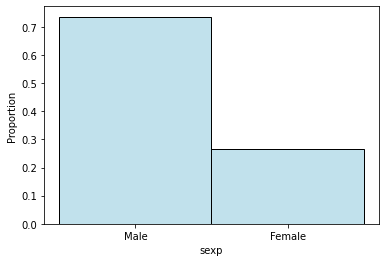

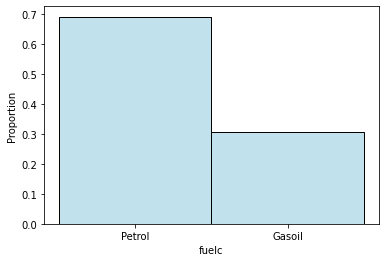

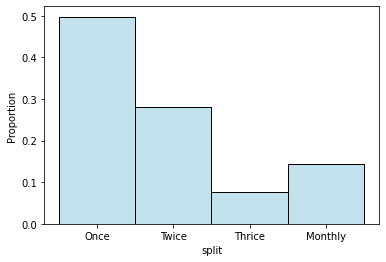

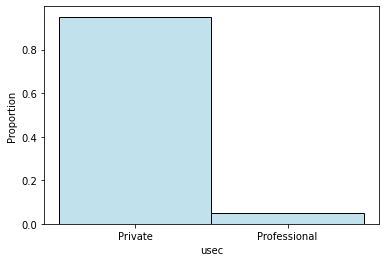

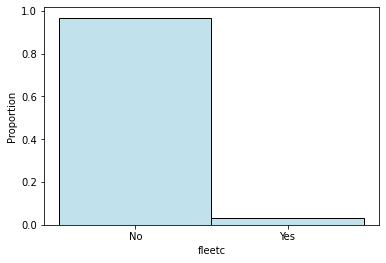

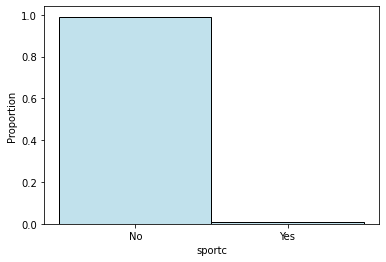

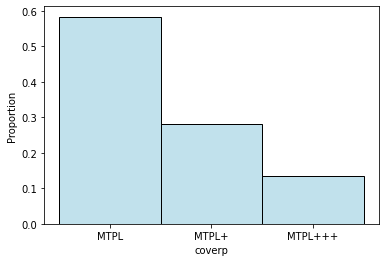

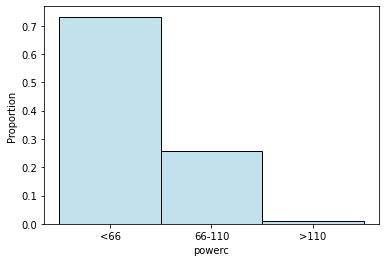

In [7]:
for col in ['agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc']:
    sns.histplot(x=col, data=df, color='lightblue', stat='proportion')
    plt.show()

#### Spatial data

Lastly we still have the postal code, let's map this to a longitude and lattitude (using a 'mapper file')

In [8]:
postal_code_df = pd.read_excel('../data/postcode_long_lat.xlsx') 

df = pd.merge(df, postal_code_df, how='inner', left_on = 'codposs', right_on = 'postcode')
df.drop(columns='postcode', inplace=True)
df.head()

,ageph,codposs,exposure,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,weighted_nbrtotc,long,lat
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,0.000000,4.356488,50.844842
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,21.470588,4.356488,50.844842
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,0.000000,4.356488,50.844842
3,62,1000,1.000000,0.000000,0,0.000000,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,0.000000,4.356488,50.844842
4,41,1000,1.000000,0.000000,1,1.000000,62.419590,6-10,Female,Petrol,Monthly,Private,No,No,MTPL,66-110,1.000000,4.356488,50.844842


Let's also create a dataframe that we will use for our partial dependece plots

In [9]:
# Dataframe we will use to plot our differences in long and lat
postal_code_df_plot = postal_code_df.copy()
postal_code_df_plot['exposure'] = 1
postal_code_df_plot['nbrtotc'] = 1
postal_code_df_plot['weighted_nbrtotc'] = postal_code_df_plot['nbrtotc'] / postal_code_df_plot['exposure']
postal_code_df_plot['ageph'] = 25
postal_code_df_plot['agecar'] = '2-5'
postal_code_df_plot['sexp'] = 'Male'
postal_code_df_plot['fuelc'] = 'Petrol'
postal_code_df_plot['split'] = 'Once'
postal_code_df_plot['usec'] = 'Private'
postal_code_df_plot['fleetc'] = 'No'
postal_code_df_plot['sportc'] = 'No'
postal_code_df_plot['coverp'] = 'MTPL'
postal_code_df_plot['powerc'] = '<66'

##### Using shapefiles to visualize spatial data

We can now use a shapefile of Belgium to visualise it. A shapefile is similar to a DataFrame, but has an extra column geometry, which can be used to draw the shapes/maps.

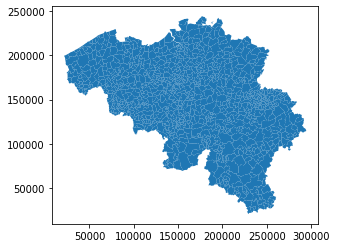

,postcode,naam1,naam2,postcodela,shape_leng,shape_area,geometry
0,1300,None,Wavre,1300,42814.060573,3.262972e+07,"POLYGON ((162947.572 159381.984, 163040.294 15..."
1,1301,None,Bierges,1301,15954.491493,9.641834e+06,"POLYGON ((162471.560 157070.795, 162293.861 15..."
2,1310,None,La Hulpe,1310,20276.463381,1.538129e+07,"POLYGON ((153194.489 158380.695, 153665.832 15..."
3,1315,None,Incourt,1315,43080.689350,3.863840e+07,"POLYGON ((175705.493 159727.847, 176442.771 15..."
4,1320,None,Beauvechain,1320,29647.869458,3.881227e+07,"POLYGON ((172550.654 164380.072, 172812.617 16..."


In [10]:
sf = gpd.read_file('../shapefile/npc96_region_Project1.shp')
sf = sf.rename(lambda x: x.lower(), axis=1)

sf.plot()
plt.show()
sf.head()

We can visualise the relative exposure per area for every city/village in Belgium.

In [11]:
by_postcode = df.groupby('codposs')['exposure'].sum()

sf = pd.merge(sf, by_postcode.to_frame(name='exposure'), how='outer', left_on='postcode', right_index=True)
sf['exposure'] = sf['exposure'].fillna(0)
sf['exposure_per_area'] = sf['exposure'] / sf['shape_area']

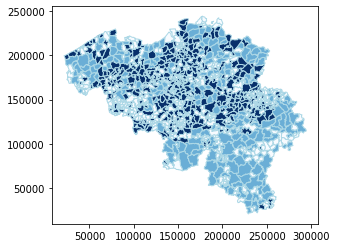

In [13]:
sf.plot(column='exposure_per_area', scheme='Quantiles', k=3, cmap='Blues', edgecolor='lightblue')
plt.show()

Clearly, the northern part (Flanders) has more exposure than the sourthern part (Wallonia). (This is due to the Ardennes).

### Univariate analysis of effect of predictor variables on claim count.

#### Age of policyholder
Effect of 'continous' age variable tells us that by aging (and getting more experienced behind the wheel), the number of claims decreases. This decrease stops at age 65). We also see the uncertainty is bigger for young and old ages (less data available).

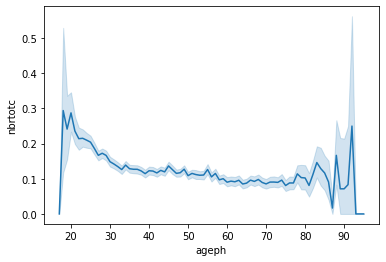

In [14]:
sns.lineplot(x='ageph', y='nbrtotc', data=df)
plt.show()

#### Continuous variables

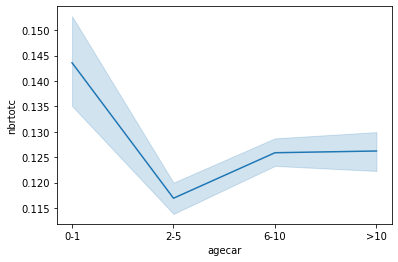

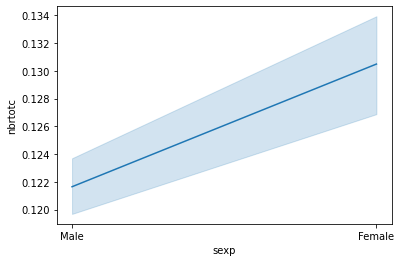

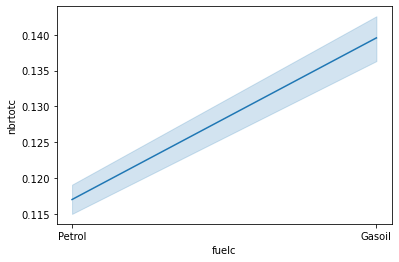

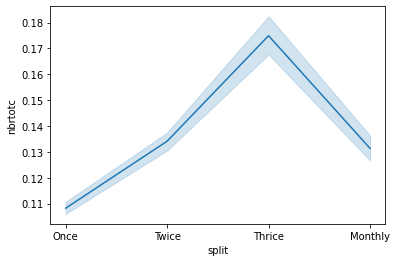

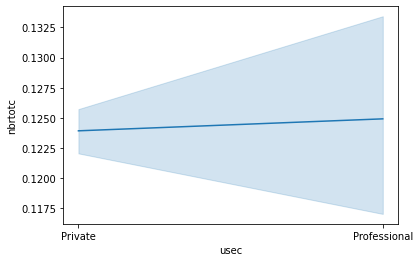

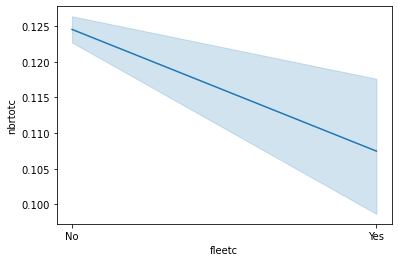

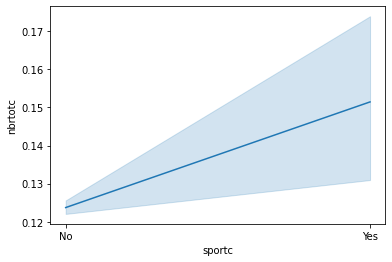

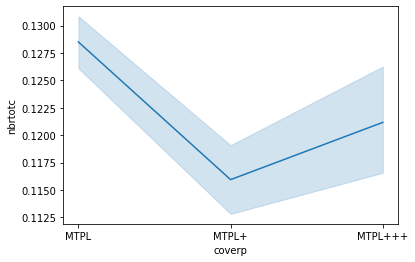

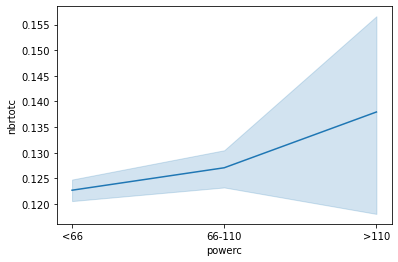

In [15]:
for col in ['agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc']:
    temp = df.groupby(col)['nbrtotc'].mean()
    sns.lineplot(x=col, y='nbrtotc', data=df)
    plt.show()

##### Interaction between age of policyholder and power of car.

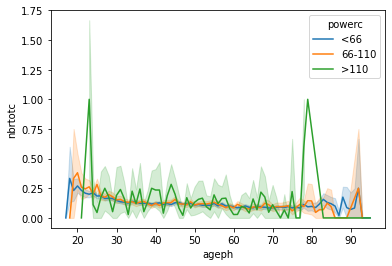

In [16]:
sns.lineplot(x='ageph', y='nbrtotc', hue='powerc', data=df)
plt.show()

## Modelling 

### Splitting in training and test
We will split the data in 70% training and 30% test. We will stratify using our reponse variable.

In [23]:
from sklearn.model_selection import train_test_split

y = df['nbrtotc']

X_train, X_test, y_train, y_test = train_test_split(df.index, y, test_size=0.3, random_state=42, stratify=y)


X_train = df.iloc[X_train]
X_test = df.iloc[X_test]
X_train.head()

,ageph,codposs,exposure,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,weighted_nbrtotc,long,lat
36405,51,4000,1.000000,0.000000,0,0.0,0.000000,6-10,Male,Petrol,Twice,Private,No,No,MTPL,<66,0.0,5.557945,50.647250
110952,34,8700,1.000000,0.000000,1,1.0,1033.319369,6-10,Male,Petrol,Once,Private,No,No,MTPL,66-110,1.0,3.353221,51.006510
49042,85,6000,0.142466,-1.948654,0,0.0,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,0.0,4.438353,50.416784
42347,35,4520,1.000000,0.000000,0,0.0,0.000000,>10,Male,Petrol,Twice,Private,No,No,MTPL+++,66-110,0.0,5.187393,50.550263
144964,36,1790,1.000000,0.000000,0,0.0,0.000000,2-5,Male,Petrol,Once,Private,No,No,MTPL,<66,0.0,4.105048,50.904112


### GAM

In [28]:
from pygam.pygam import PoissonGAM
from pygam import s, te, f

In [29]:
# List of available predictors
predictor_vars = ['ageph', 'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc', 'long', 'lat']
categorical_vars = ['agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc']

# Preprocessing for GAM
y = X_train['weighted_nbrtotc'].values

exposure = X_train['exposure'].values
spatial_plot_exposure = postal_code_df_plot['exposure'].values

temp = X_train[predictor_vars].copy()
spatial_temp = postal_code_df_plot[predictor_vars].copy()


temp[categorical_vars] = temp[categorical_vars].apply(lambda col:pd.Categorical(col).codes)
X = temp.values

spatial_temp[categorical_vars] = spatial_temp[categorical_vars].apply(lambda col:pd.Categorical(col).codes)
spatial_plot_X = spatial_temp.values

In [30]:
# Fit GAM
gam = PoissonGAM(s(0) + f(1) + f(2) + f(3) + f(4) + f(8) + f(9) + te(10, 11))
gam.fit(X, y, weights=exposure)
gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     55.8473
Link Function:                          LogLink Log Likelihood:                                -43921.7287
Number of Samples:                       114559 AIC:                                             87955.152
                                                AICc:                                           87955.2094
                                                UBRE:                                                2.537
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0316
Feature Function                  Lam

C:\Users\thi12\AppData\Local\Temp/ipykernel_13304/4162135137.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Using AIC this is our best model (Using a grid search better models might get found).

We can now visualise the different smoothers

**Age smoother**

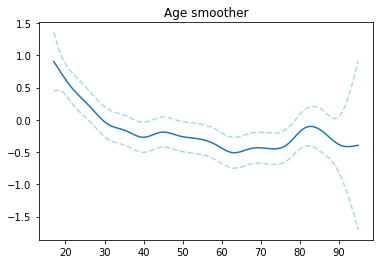

In [80]:
# Visualise age term (second term in our GAM)
XX = gam.generate_X_grid(term=0)

# Age is first term in our data X
# Best fit
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
# Confidence intervals
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX, width=.95)[1], c='lightblue', ls='--')
plt.title('Age smoother')
plt.show()

**Spatial smoother**

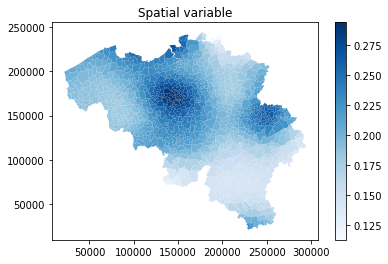

In [31]:
# Visualise our spatial smoother using our shapefile
postal_code_df_plot['GAM_predictions'] = pd.Series(gam.predict(spatial_plot_X, exposure=spatial_plot_exposure))
sf['GAM_prediction'] = postal_code_df_plot['GAM_predictions']


sf.plot(column='GAM_prediction', cmap='Blues', legend=True)
plt.title('Spatial variable')
plt.show()


#### How does our test set do?

In [33]:
y_test_GAM = X_test['weighted_nbrtotc'].values
exposure_test_GAM = X_test['exposure'].values

X_df = X_test[predictor_vars].copy()
X_df[categorical_vars] = X_df[categorical_vars].apply(lambda col:pd.Categorical(col).codes)

X_test_GAM = X_df.values

In [34]:
from sklearn.metrics import mean_poisson_deviance

y_pred_GAM = gam.predict(X_test_GAM)
print(f'Poisson deviance: {mean_poisson_deviance(y_test_GAM, y_pred_GAM, sample_weight=exposure_test_GAM)}')

Poisson deviance: 0.6016479756361374


## From GAM to GLM (that can become a tariff table (only categorical variables)

We first need to convert our continuous variables into categorical variables.

We can do this by using some clever binning algorithms.

In [35]:
from optbinning import ContinuousOptimalBinning

optb_postcode = ContinuousOptimalBinning(name='spatial', dtype='categorical', max_n_bins=5)

optb_postcode.fit(sf['postcode'].values, sf['GAM_prediction'].values)

X_train['codposs_bin'] = optb_postcode.transform(X_train['codposs'].values, metric='indices')
X_train['codposs_bin'] = X_train['codposs_bin'].astype('category')
X_test['codposs_bin'] = optb_postcode.transform(X_test['codposs'].values, metric='indices')
X_test['codposs_bin'] = X_test['codposs_bin'].astype('category')

C:\Users\thi12\AppData\Local\Temp/ipykernel_13304/3967988121.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['codposs_bin'] = optb_postcode.transform(X_train['codposs'].values, metric='indices')
C:\Users\thi12\AppData\Local\Temp/ipykernel_13304/3967988121.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['codposs_bin'] = X_train['codposs_bin'].astype('category')
C:\Users\thi12\AppData\Local\Temp/ipykernel_13304/3967988121.py:9: SettingWithCopyWarning: 
A value is trying to be set on a 

In [36]:
optb_age = ContinuousOptimalBinning(name='age', dtype='numerical', max_n_bins=5)

gam.predict(X, exposure=exposure)
optb_age.fit(X[:,0], gam.predict(X, exposure=exposure))

X_train['ageph_bin'] = optb_age.transform(X_train['ageph'].values, metric='indices')
X_train['ageph_bin'] = X_train['ageph_bin'].astype('category')
X_test['ageph_bin'] = optb_age.transform(X_test['ageph'].values, metric='indices')
X_test['ageph_bin'] = X_test['ageph_bin'].astype('category')

C:\Users\thi12\AppData\Local\Temp/ipykernel_13304/3294211537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ageph_bin'] = optb_age.transform(X_train['ageph'].values, metric='indices')
C:\Users\thi12\AppData\Local\Temp/ipykernel_13304/3294211537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ageph_bin'] = X_train['ageph_bin'].astype('category')
C:\Users\thi12\AppData\Local\Temp/ipykernel_13304/3294211537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Now that the binning is done, we can fit a GLM

In [37]:
X_train.head()

,ageph,codposs,exposure,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,...,usec,fleetc,sportc,coverp,powerc,weighted_nbrtotc,long,lat,codposs_bin,ageph_bin
36405,51,4000,1.000000,0.000000,0,0.0,0.000000,6-10,Male,Petrol,...,Private,No,No,MTPL,<66,0.0,5.557945,50.647250,1,2
110952,34,8700,1.000000,0.000000,1,1.0,1033.319369,6-10,Male,Petrol,...,Private,No,No,MTPL,66-110,1.0,3.353221,51.006510,1,2
49042,85,6000,0.142466,-1.948654,0,0.0,0.000000,>10,Female,Petrol,...,Private,No,No,MTPL+,<66,0.0,4.438353,50.416784,1,4
42347,35,4520,1.000000,0.000000,0,0.0,0.000000,>10,Male,Petrol,...,Private,No,No,MTPL+++,66-110,0.0,5.187393,50.550263,1,2
144964,36,1790,1.000000,0.000000,0,0.0,0.000000,2-5,Male,Petrol,...,Private,No,No,MTPL,<66,0.0,4.105048,50.904112,4,2


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

linear_model_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OneHotEncoder(),
            ['ageph_bin', "agecar", "sexp", "fuelc", "split", "coverp", 'powerc', 'codposs_bin'],
        ),
    ],
    remainder="drop",
)

model = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=0)),
    ]
).fit(X_train, X_train['weighted_nbrtotc'], regressor__sample_weight=X_train["exposure"])


Let's visualise our spatial plot.

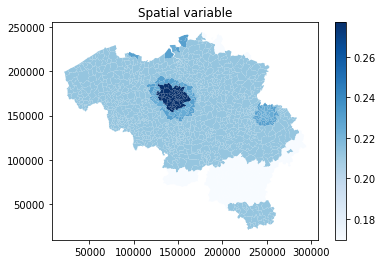

In [39]:
postal_code_df_plot['codposs_bin'] = optb_postcode.transform(postal_code_df_plot['postcode'].values, metric='indices')
postal_code_df_plot['codposs_bin'] = postal_code_df_plot['codposs_bin'].astype('category')

postal_code_df_plot['ageph_bin'] = optb_age.transform(postal_code_df_plot['ageph'].values, metric='indices')
postal_code_df_plot['ageph_bin'] = postal_code_df_plot['ageph_bin'].astype('category')


postal_code_df_plot['GLM_predictions'] = pd.Series(model.predict(postal_code_df_plot))
sf['GLM_predictions'] = postal_code_df_plot['GLM_predictions']


sf.plot(column='GLM_predictions', cmap='Blues', legend=True)
plt.title('Spatial variable')
plt.show()

How does our test set do?

In [40]:
y_pred_GLM = model.predict(X_test)
print(f'Poisson deviance: {mean_poisson_deviance(X_test["weighted_nbrtotc"], y_pred_GLM, sample_weight=X_test["exposure"])}')


Poisson deviance: 0.6028182013407477


## Conclusion between GAM and GLM

Poisson deviance GAM: 0.6016479756361374

Poisson deviance GLM: 0.6028182013407477


We see that the Poisson deviance on our test set is almost the same for the GLM and the GAM.

As a result, we would prefer the GLM as it's more simple and can easily be turned into a tariff table.

## GBM

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import GridSearchCV


tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            categorical_vars,
        ),
        (
            "numeric", 
            "passthrough", 
            ["ageph", "long", "lat"]
        ),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        (
            "preprocessor", 
            tree_preprocessor
        ),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson"),
        ),
    ]
)

parameters = {
    'regressor__max_iter': [1000,1500],
    'regressor__learning_rate': [0.01,0.025,0.04],
             }
search = GridSearchCV(poisson_gbrt, parameters, n_jobs=2, cv=5)

search.fit(
    X_train, X_train["weighted_nbrtotc"], regressor__sample_weight=X_train["exposure"]
)





Let's again plot our spatial variable

In [ ]:
postal_code_df_plot['GBM_predictions'] = pd.Series(
    search.predict(postal_code_df_plot)
)
sf['GBM_predictions'] = postal_code_df_plot['GBM_predictions']



sf.plot(column='GBM_predictions', cmap='Blues', legend=True)
plt.title('Spatial variable')
plt.show()

Let's see how our test set performs

In [ ]:
y_pred_GBM = search.predict(X_test)

dev = mean_poisson_deviance( X_test["weighted_nbrtotc"], y_pred_GBM, sample_weight=X_test["exposure"])
print(
    f'Poisson deviance: { dev }'
)

## Conclusion between GBM and GLM

Poisson deviance GBM: 0.6006626785435674

Poisson deviance GLM: 0.6028182013407477

We can see that the GBM performs better than the GLM. But a GLM is more simple.